In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
grouped = pd.read_csv('./20220615_total.csv')

In [3]:
meta = pd.read_csv("../tensorMaker/nftMetaData.csv")

In [4]:
import numpy as np
from math import log2
import pandas as pd
import sqlite3

# Create a SQL connection to our SQLite database
con = sqlite3.connect("../DataOtherSources/EthereumNFTs/nfts.sqlite")

cur = con.cursor()
currentOwners = pd.read_sql_query("SELECT * from current_owners", con)
# print(df.head(10))
# Be sure to close the connection
con.close()

groupedOwners = currentOwners.groupby("nft_address")
entropyPandas = []

def entropy(labels):
    #.....................................
    uniqueLabels = np.unique(labels, return_counts=True)
    totalSumProbabilities = 0
    listLength = len(labels)
    for variableCount in uniqueLabels[1]:
        label_Probability = variableCount / (listLength)
        label_Entropy = label_Probability * log2(label_Probability)
        totalSumProbabilities += label_Entropy
    # print(-totalSumProbabilities)
    return -totalSumProbabilities


for (nftName, groupobject) in groupedOwners.__iter__():
        entropyScore = entropy(groupobject["owner"])
        entropyPandas.append({
            "nft":nftName.lower(),
            "entropyScore":entropyScore
        })

In [5]:
entropyPandas = pd.DataFrame(entropyPandas)

In [6]:
grouped['timeStamp'] = pd.to_datetime(grouped['timeStamp'], utc=True)
grouped["timeStamp-day"] = grouped['timeStamp'].dt.floor('D')
grouped["nft_address"] = grouped["nft_address"].str.lower()

In [7]:
from scipy.stats import kurtosis
pivot_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum)
pivot_mean_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean)
# pivot_mean_ETH_log = pd.pivot_table(grouped, values="transactionEther_average", index="timeStamp-day", columns="nft_address", aggfunc=np.mean)
pivot_max_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.max)
pivot_change_in_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_change_in_log_prices = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_kurt_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=kurtosis)

In [8]:
tensor = np.array([
    pivot_trades,
    pivot_max_log,
    pivot_change_in_trades,
    pivot_change_in_log_prices,
    pivot_kurt_log,
    pivot_mean_log,
    # pivot_mean_ETH_log
])

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
clusterDataList = []
errorList = []
for series in range(tensor.shape[2]):
    clusterData = {}
    
    data = tensor[:,:, series]

    clusterData['nft']=pivot_trades.iloc[:,series].name
    clusterData['Length']=len(data[0,:][~np.isnan(data[0,:])])

    clusterData['changeSquared_trade']=np.mean(np.power(data[2,:][~np.isnan(data[2,:])],2))
    
    clusterData['changeSquared_price']=np.mean(np.power(data[3,:][~np.isnan(data[3,:])],2))
    clusterData['changeCube_price']=np.mean(np.power(data[3,:][~np.isnan(data[3,:])],3))

    for statisticsSeries in range(tensor.shape[0]):
        try:
            clusterData[statisticsSeries,'average'] =np.average(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'median'] =np.nanmedian(data[statisticsSeries,:])
            clusterData[statisticsSeries,'var'] =np.nanvar(data[statisticsSeries,:])
            clusterData[statisticsSeries,'mean'] = np.nanmean(data[statisticsSeries,:])
            clusterData[statisticsSeries,'std'] =np.nanstd(data[statisticsSeries,:])
            clusterData[statisticsSeries,'max'] =np.max(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'min'] =np.min(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'sum'] =np.sum(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'kurtosis'] = kurtosis(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterDataList.append(clusterData)
        except Exception:
            continue
            # errorData = {}
            # errorData["Err"] = data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])]
            # errorList.append(errorData)
            
    
err = pd.DataFrame(errorList)
x = pd.DataFrame(clusterDataList)

c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-9-3682be0fe87c>:23: RuntimeWarning: Degrees of freedom <= 0 for slice.
  clusterData[statisticsSeries,'var'] =np.nanvar(data[statisticsSeries,:])
<ipython-input-9-3682be0fe87c>:24: RuntimeWarning: Mean of empty slice
  clusterData[statisticsSeries,'mean'] = np.nanmean(data[statis

In [10]:
X_dropped=x.drop_duplicates()

In [11]:
X_dropped = X_dropped.dropna(axis=0, how='any')

In [12]:
X_dropped =pd.merge(X_dropped, meta, on="nft")
X_dropped =pd.merge(X_dropped, entropyPandas, on="nft")

In [13]:
X_dropped.shape

(3732, 68)

In [14]:
X_labels = pd.DataFrame(X_dropped.iloc[:,1])

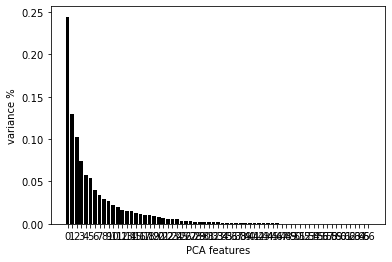

In [15]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = X_dropped.iloc[:,1:]
X_std = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X_std)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

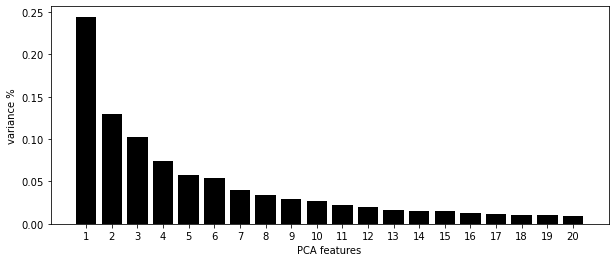

In [16]:
featuresTicks = range(1,21)
plt.figure(figsize=(10, 4))
plt.bar(featuresTicks, pca.explained_variance_ratio_[:20], color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(featuresTicks)
plt.savefig('pcaFeatures.png')
plt.show()

In [17]:
np.sum(pca.explained_variance_ratio_[:7])

0.702485737945177

In [18]:
tSNE = TSNE(n_components=3)
tSNE_COMPS = tSNE.fit_transform(PCA_components)

tSNE_PCA_components = pd.DataFrame(tSNE_COMPS)

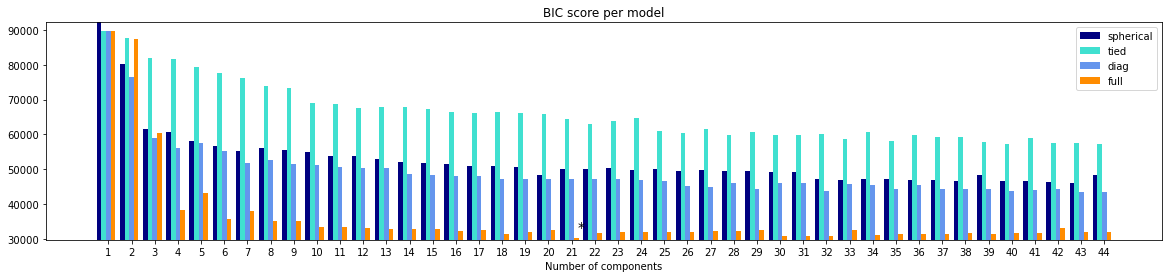

In [19]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 45)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(PCA_components.iloc[:,:5])
        bic.append(gmm.bic(PCA_components.iloc[:,:5]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(20, 4))
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)
plt.show()

In [64]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import mixture

n_components = 21
features = 5
gmm = mixture.GaussianMixture(
    n_components=n_components
)

gmm_labels = gmm.fit_predict(PCA_components.iloc[:,:features])
X_dropped["labels-kmeans-tSNEPCA-"+str(n_components)+"-"+str(features)] = gmm_labels
X_labels["labels-kmeans-tSNEPCA-"+str(n_components)+"-"+str(features)] = gmm_labels

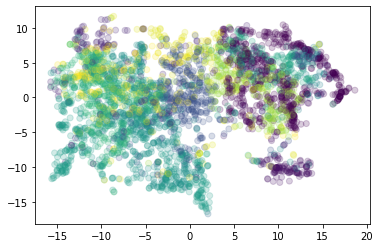

In [71]:
plt.scatter(tSNE[0], tSNE[2], c=gmm_labels, alpha=.2)
plt.show()

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = X_dropped.iloc[:,1:]
X_std = StandardScaler().fit_transform(X)

tSNE = TSNE(n_components=3)
tSNE_COMPS = tSNE.fit_transform(X_std)

tSNE = pd.DataFrame(tSNE_COMPS)

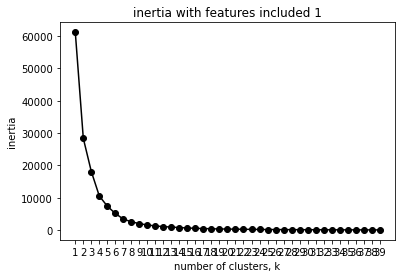

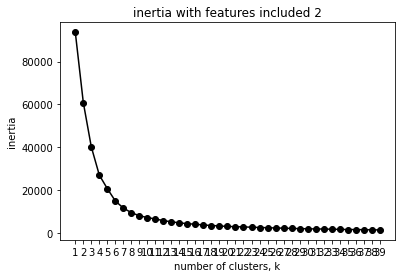

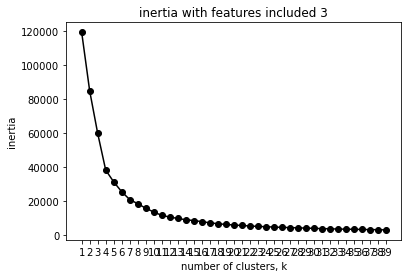

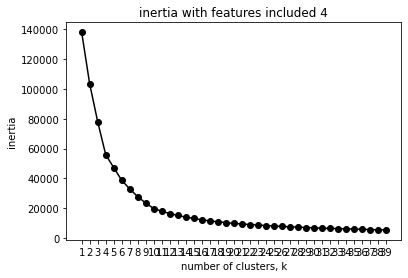

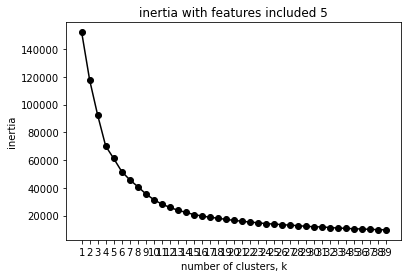

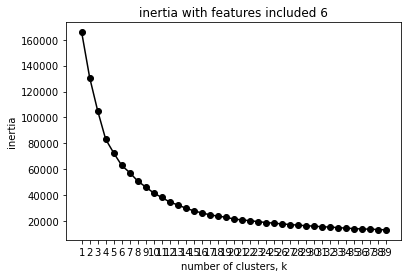

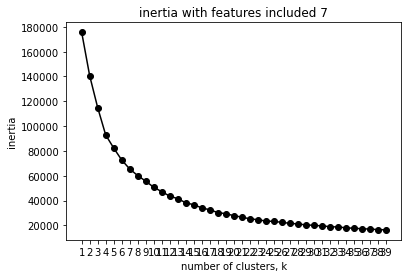

In [21]:
ks = range(1, 40)
features = range(1,8)

for feature in features:
    inertias = []

    for k in ks:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k)
        
        # Fit model to samples
        model.fit(PCA_components.iloc[:,:feature])
        
        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)
    
    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia with features included '+str(feature))
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

In [22]:
clusters = 5
features = 1
kmeanstPCA = KMeans(n_clusters=clusters)
labels = kmeanstPCA.fit_predict(PCA_components.iloc[:,:features])

X_dropped["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels

X_labels["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels


In [23]:
clusters = 7
features = 4
kmeanstPCA = KMeans(n_clusters=clusters)
labels = kmeanstPCA.fit_predict(PCA_components.iloc[:,:features])
X_dropped["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels
X_labels["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels

In [24]:
clusters = 10
features =  5 
kmeanstPCA = KMeans(n_clusters=clusters)
labels = kmeanstPCA.fit_predict(PCA_components.iloc[:,:features])
X_dropped["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels
X_labels["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels

In [25]:
clusters = 7
features = 3
kmeanstPCA = KMeans(n_clusters=clusters)
labels = kmeanstPCA.fit_predict(PCA_components.iloc[:,:features])
X_dropped["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels
X_labels["labels-kmeans-tSNEPCA-"+str(clusters)+"-"+str(features)] = labels

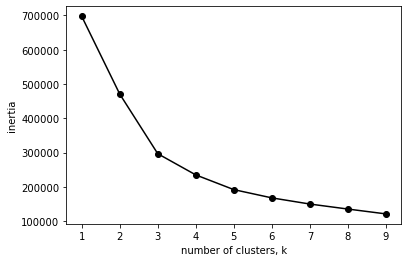

In [26]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tSNE)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

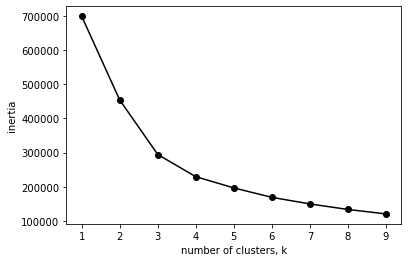

In [27]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    preds = model.fit_predict(tSNE_PCA_components)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [28]:
# # Dendogram for Heirarchical Clustering
# import scipy.cluster.hierarchy as shc
# from matplotlib import pyplot
# pyplot.figure(figsize=(10, 7))  
# pyplot.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(tSNE, method='ward'))

In [29]:
# # Dendogram for Heirarchical Clustering
# import scipy.cluster.hierarchy as shc
# from matplotlib import pyplot
# pyplot.figure(figsize=(10, 7))
# pyplot.title("Dendrograms")
# dend = shc.dendrogram(shc.linkage(PCA_components.iloc[:,:5], method='ward'))

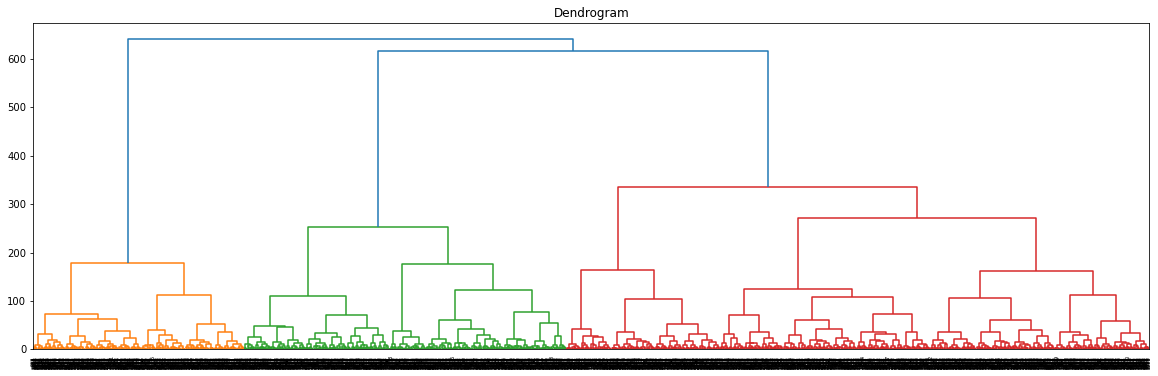

In [30]:
# Dendogram for Heirarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(20, 6))
pyplot.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(tSNE_PCA_components, method='ward'))

In [31]:
kmeanstSNE = KMeans(n_clusters=3)
labels = kmeanstSNE.fit_predict(tSNE)
X_dropped["labels-kmeans-tSNE"] = labels
X_labels["labels-kmeans-tSNE"] = labels

In [32]:
kmeanstPCA = KMeans(n_clusters=3)
labels = kmeanstPCA.fit_predict(PCA_components.iloc[:,:5])
X_dropped["labels-kmeans-tSNEPCA-5-4"] = labels
X_labels["labels-kmeans-tSNEPCA-5-4"] = labels

In [33]:
kmeanstSNEPCA = KMeans(n_clusters=3)
labels = kmeanstSNEPCA.fit_predict(tSNE_PCA_components)
X_dropped["labels-kmeans-tSNEPCA-3"] = labels
X_labels["labels-kmeans-tSNEPCA-3"] = labels

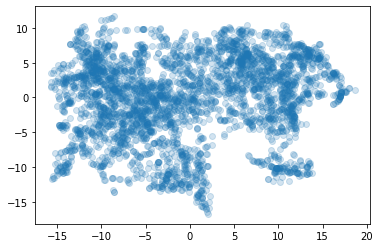

In [34]:
plt.scatter(tSNE[0], tSNE[2], alpha=.2)
plt.show()

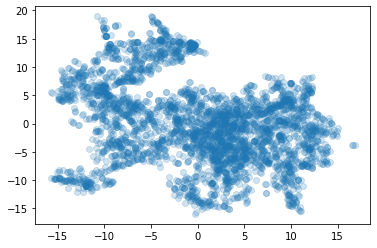

In [35]:
plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[2], alpha=.2)
plt.show()

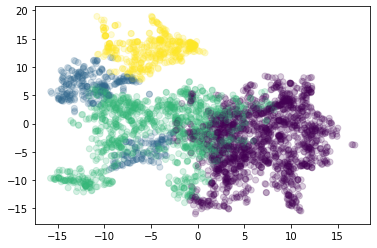

In [36]:
from sklearn.mixture import GaussianMixture

gaussianModel = GaussianMixture(n_components=4)
labelsGaustSNEPCA = gaussianModel.fit_predict(tSNE_PCA_components)

X_dropped["labels-gaussian-tSNEPCA-4"] = labels
X_labels["labels-gaussian-tSNEPCA-4"] = labels

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[2], c=labelsGaustSNEPCA, alpha=.2)
plt.show()

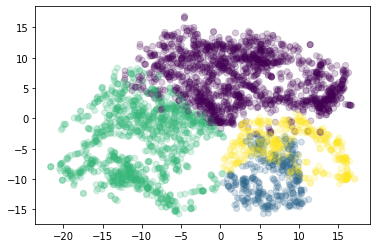

In [37]:
plt.scatter(tSNE_PCA_components[1], tSNE_PCA_components[0], c=labelsGaustSNEPCA, alpha=.2)
plt.show()

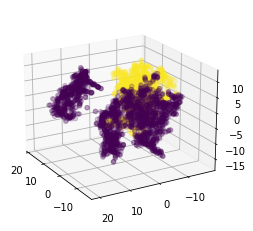

In [38]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(tSNE[0], tSNE[1], tSNE[2], c=labelsGaustSNEPCA==2, alpha=.2)
ax.view_init(elev=20., azim=150)

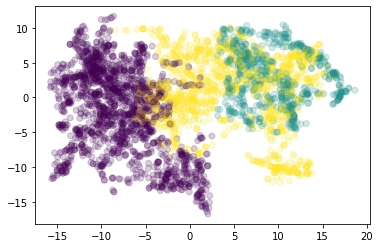

In [39]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=3)
labelsAgglotSNE = clustering.fit_predict(tSNE)

X_dropped["labels-Agglo-tSNE-3"] = labelsAgglotSNE
X_labels["labels-Agglo-tSNE-3"] = labelsAgglotSNE

plt.scatter(tSNE[0], tSNE[2], c=labelsAgglotSNE, alpha=.2)
plt.show()

In [40]:
X_dropped.iloc[0:1,46]

0    0.956916
Name: (5, std), dtype: float64

In [74]:
X_dropped.iloc[:,45]

0       1.457297
1       0.000000
2       1.420607
3       1.799297
4       0.338451
          ...   
3727    0.202369
3728    0.263801
3729    1.022776
3730    1.758947
3731    0.000000
Name: (5, mean), Length: 3732, dtype: float64

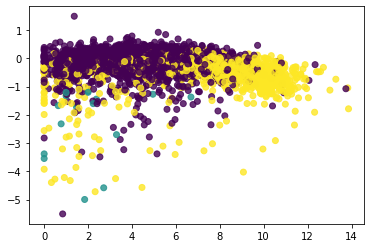

In [78]:
plt.scatter(X_dropped.iloc[:,44], np.log10(X_dropped.iloc[:,44]), c=labelsAgglotSNE, alpha=.8)
plt.show()

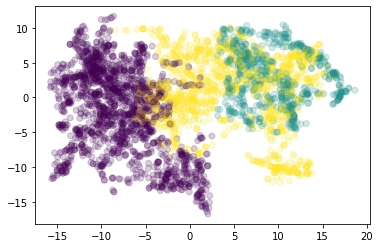

In [80]:
plt.scatter(tSNE[0], tSNE[2], c=labelsAgglotSNE, alpha=.2)
plt.savefig('Agglo-tSNE.png', dpi=400)
plt.show()

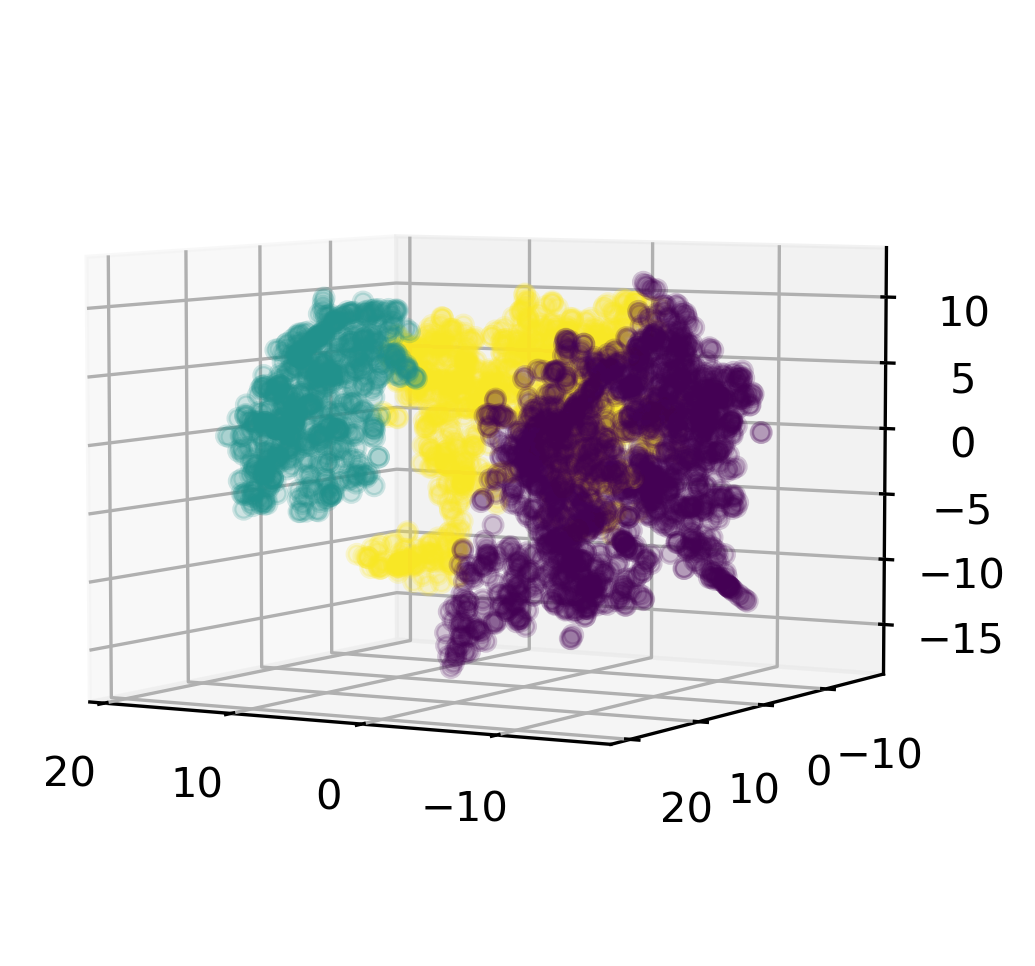

In [43]:
from mpl_toolkits.mplot3d import Axes3D

azim = 120

fig = plt.figure(dpi=300)
ax = plt.axes(projection='3d')
ax.scatter3D(tSNE[0], tSNE[1], tSNE[2], c=labelsAgglotSNE, alpha=.2)
ax.view_init(elev=5., azim=azim)
plt.savefig('Agglo-tSNE-3D-'+ str(azim)+'.png', dpi=400)
plt.show()

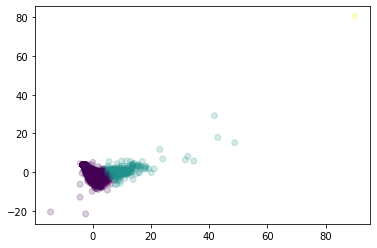

In [44]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=3)
labelsAggloPCA = clustering.fit_predict(PCA_components.iloc[:,:5])

X_dropped["labels-Agglo-PCA"] = labelsAggloPCA
X_labels["labels-Agglo-PCA"] = labelsAggloPCA

plt.scatter(PCA_components[0], PCA_components[1], c=labelsAggloPCA, alpha=.2)
plt.show()

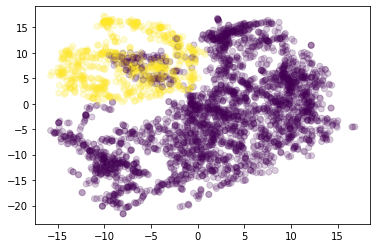

In [45]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=2)
labelsAgglotSNEPCA = clustering.fit_predict(tSNE_PCA_components)

X_dropped["labels-Agglo-tSNEPCA-2"] = labelsAgglotSNEPCA
X_labels["labels-Agglo-tSNEPCA-2"] = labelsAgglotSNEPCA

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

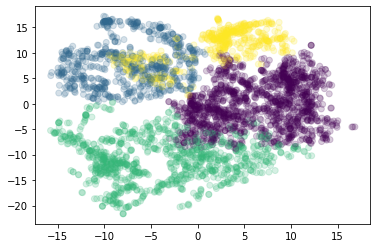

In [46]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=4)
labelsAgglotSNEPCA4 = clustering.fit_predict(tSNE_PCA_components)

X_dropped["labels-Agglo-tSNEPCA-4"] = labelsAgglotSNEPCA4
X_labels["labels-Agglo-tSNEPCA-4"] = labelsAgglotSNEPCA4

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA4, alpha=.2)
plt.show()

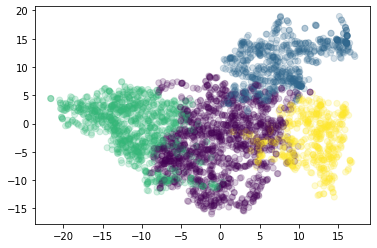

In [47]:
plt.scatter(tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA4, alpha=.2)
plt.show()

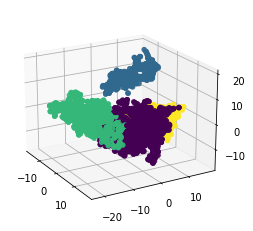

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(tSNE_PCA_components[0], tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA4, alpha=.9)
ax.view_init(elev=20., azim=330)

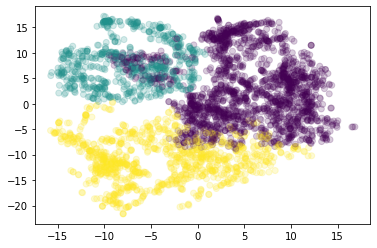

In [49]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=3)
labelsAgglotSNEPCA = clustering.fit_predict(tSNE_PCA_components)

X_dropped["labels-Agglo-tSNEPCA-3"] = labelsAgglotSNEPCA
X_labels["labels-Agglo-tSNEPCA-3"] = labelsAgglotSNEPCA

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

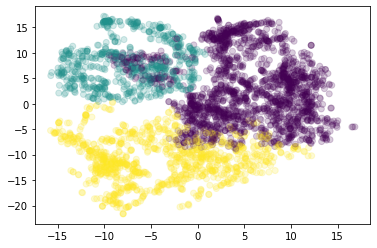

In [50]:
plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

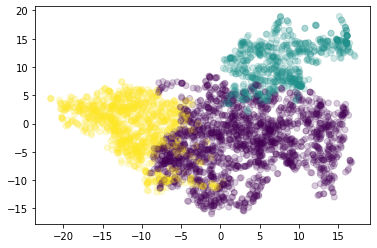

In [51]:
plt.scatter(tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

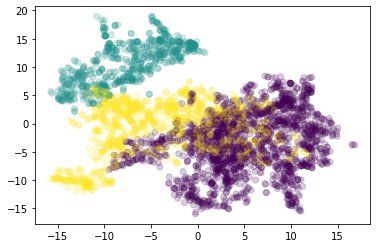

In [52]:
plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[2], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

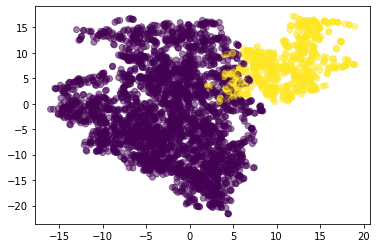

In [53]:
plt.scatter(tSNE_PCA_components[2], tSNE_PCA_components[1], c=labelsAgglotSNEPCA==1, alpha=.5)
plt.show()

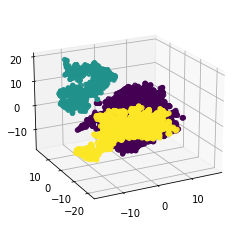

In [54]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(tSNE_PCA_components[0], tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA, alpha=.9)
ax.view_init(elev=20., azim=243)

In [55]:
nftAddressNames = pd.read_csv("../webscraper/nftNames-baseline.csv")

nftNames = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["name"]))
nftSymbol = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["symbol"]))


In [56]:
X_dropped["name"] = X_dropped["nft"].replace(nftNames)
X_dropped["symbol"] = X_dropped["nft"].replace(nftSymbol)

In [57]:
import numpy as np
import sklearn.metrics as skMetrics
labels = X_labels.iloc[:,1:]
comparison = labels.shape[1]
comp_square = np.zeros((comparison,comparison))

for x in range(comparison):
    for y in range(comparison):
        comp_square[x][y] = skMetrics.adjusted_rand_score(labels.iloc[:,x], labels.iloc[:,y])

np.savetxt("modelComp.csv", comp_square, delimiter=",")

In [58]:
np.savetxt("labels.csv",np.array(labels.columns), delimiter=",", fmt='%s')

In [59]:
X_dropped.to_csv("total_with_labels.csv")

In [60]:

# # the histogram of the data
# n, bins, patches = plt.hist(X_dropped[X_dropped["labels-Agglo-tSNE"]==1].iloc[:,7])
# # n, bins, patches = plt.hist(X_dropped[X_dropped["labels-Agglo-tSNE"]==1]["changeSquared_trade"])

# plt.grid(True)
# plt.show()

In [61]:
from scipy.stats import f_oneway,normaltest,bartlett

setToCompare = "labels-Agglo-tSNE-3"
catGroupList = X_dropped.groupby(setToCompare)["entropyScore"].apply(list)

for i in range(len(catGroupList)):
    print(normaltest(catGroupList[i]))

anovaResult = f_oneway(*catGroupList)
print(anovaResult)
print(bartlett(*catGroupList))

NormaltestResult(statistic=27.532623893417707, pvalue=1.0504289570374495e-06)
NormaltestResult(statistic=40.34365480796672, pvalue=1.7357479801293911e-09)
NormaltestResult(statistic=183.66321873356856, pvalue=1.3123170994557945e-40)
F_onewayResult(statistic=1195.8366288171628, pvalue=0.0)
BartlettResult(statistic=176.9022662154527, pvalue=3.8562126345448284e-39)


In [62]:
catGroupList

labels-Agglo-tSNE-3
0    [2.10400191997576, 6.455976613609663, 3.219528...
1    [2.321928094887362, 1.438826429298142, 2.0, 3....
2    [9.340784296977835, 9.818632506599934, 1.52192...
Name: entropyScore, dtype: object

In [63]:
import scipy.stats as scStat

setToCompare = "labels-Agglo-tSNE-3"
clusters = len(X_dropped[setToCompare].unique())


for i in range(clusters):
    normality_priceStab = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"])
    print("Normality change price",normality_priceStab)
    print("mean change price",np.mean(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"]))
    print("")

    normality_changeTrade = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"])
    print("Normality changetrade",normality_changeTrade)
    print("")

    normality_meanLogPrice = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i].iloc[:,53])
    print("Normality meanlog price",normality_meanLogPrice)
    print("")


    print("mean change trade",np.mean(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"]))
    print("mean quant trade",np.mean(X_dropped[X_dropped[setToCompare]==i].iloc[:,8]))
    print("")

    for z in range(clusters):
        tTest = 0
        if i != z: 
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"],X_dropped[X_dropped[setToCompare]==z]["changeSquared_price"])
            print("Compare cluster change price", i, " against:", z, ":", tTest)
            print("")
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"],X_dropped[X_dropped[setToCompare]==z]["changeSquared_trade"])
            print("Compare cluster change in trade", i, " against:", z, ":", tTest)
            print("")
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i].iloc[:,8],X_dropped[X_dropped[setToCompare]==z].iloc[:,8])
            print("Compare cluster quantity trade", i, " against:", z, ":", tTest)
            print("")
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i].iloc[:,53],X_dropped[X_dropped[setToCompare]==z].iloc[:,53])
            print("Compare cluster mean log price", i, " against:", z, ":", tTest)
            print("")
    print("")
    print("")
    print("")
    print("")

Normality change price NormaltestResult(statistic=4730.3638255564165, pvalue=0.0)
mean change price 1.8023365904515312

Normality changetrade NormaltestResult(statistic=3545.554561776664, pvalue=0.0)

Normality meanlog price NormaltestResult(statistic=3714.8307612788853, pvalue=0.0)

mean change trade 307.74313989394193
mean quant trade 4.189682081411451

Compare cluster change price 0  against: 1 : Ttest_indResult(statistic=8.525436181503885, pvalue=2.6054546353538672e-17)

Compare cluster change in trade 0  against: 1 : Ttest_indResult(statistic=2.1979322039332274, pvalue=0.02804616738255884)

Compare cluster quantity trade 0  against: 1 : Ttest_indResult(statistic=4.398238485246908, pvalue=1.1374501841314272e-05)

Compare cluster mean log price 0  against: 1 : Ttest_indResult(statistic=-3.1085000198347013, pvalue=0.0019017513591546278)

Compare cluster change price 0  against: 2 : Ttest_indResult(statistic=7.87465861204958, pvalue=4.722200278375406e-15)

Compare cluster change in tr